In [41]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from dfply import *
import numpy as np
from plotnine import *

In [5]:
df = pd.read_csv('../Data/df_satisfaction_rdq_dx_demo.csv', low_memory=False)


In [6]:
dfMDD = df[df.mddsnp_1.str.contains('Curr, Prin') | df.mddrnp_1.str.contains('Curr, Prin')]

In [7]:
dfMDD.loc[:,('pre_dsym')] = dfMDD.filter(regex='rdqpre_[1-9]_|rdqpre_1[0-4]_').mean(axis = 1)
dfMDD['pre_ndsym'] = dfMDD.filter(regex='rdqpre_1[5-9]_|rdqpre_2[0-5]_').mean(axis = 1)
dfMDD['post_dsym'] = dfMDD.filter(regex='rdqpost_[1-9]_|rdqpost_1[0-4]_').mean(axis = 1)
dfMDD['post_ndsym'] = dfMDD.filter(regex='rdqpost_1[5-9]_|rdqpost_2[0-5]_').mean(axis = 1)

In [110]:
labels = ['dsym', 'ndsym', 'cope', 'pmh', 'fun', 'well']
for label in labels:
    dfMDD['change_'+ label] = dfMDD.filter(regex='^post_'+label).squeeze() - dfMDD.filter(regex='^pre_'+label).squeeze()


dfMDD.change_dsym = dfMDD.change_dsym*(-1)
dfMDD.change_ndsym = dfMDD.change_ndsym*(-1)
dfMDD.to_csv('../Data/dfMDD_satisfaction_rdq_dx_demo.csv')

In [9]:
print(
    'Number of People with Signifiacnt Depressive Symptom Reduction:', sum(dfMDD.change_dsym >= 0.5), '\n',
    'Number of People with Signifiacnt Non-Depressive Symptom Reduction:', sum(dfMDD.change_ndsym >= 0.5), '\n',
    'Number of People with Signifiacnt Coping Improvement:', sum(dfMDD.change_cope >= 0.5), '\n',
    'Number of People with Signifiacnt Positve Mental Health Improvement:', sum(dfMDD.change_pmh >= 0.5), '\n',
    'Number of People with Signifiacnt Functioning Improvement:', sum(dfMDD.change_fun >= 0.5), '\n',
    'Number of People with Signifiacnt Well-Being Improvement:', sum(dfMDD.change_well >= 0.5))

Number of People with Signifiacnt Depressive Symptom Reduction: 672 
 Number of People with Signifiacnt Non-Depressive Symptom Reduction: 628 
 Number of People with Signifiacnt Coping Improvement: 607 
 Number of People with Signifiacnt Positve Mental Health Improvement: 668 
 Number of People with Signifiacnt Functioning Improvement: 569 
 Number of People with Signifiacnt Well-Being Improvement: 715


In [25]:
cut = 0.5
for label in labels:
    dfMDD['change_'+label+'_cut'] = dfMDD['change_'+label] >= cut
    dfMDD['change_'+label+'_cut'] = dfMDD['change_'+label+'_cut'].replace({True: 1, False: 0}).astype('category')

In [26]:
dfMDD.filter(regex= 'change_('+'|'.join(map(str, labels)) +')_cut').astype('float').corr()

,change_dsym_cut,change_ndsym_cut,change_cope_cut,change_pmh_cut,change_fun_cut,change_well_cut
change_dsym_cut,1.000000,0.550282,0.384805,0.511554,0.396172,0.475939
change_ndsym_cut,0.550282,1.000000,0.323283,0.392762,0.323199,0.365179
change_cope_cut,0.384805,0.323283,1.000000,0.438102,0.415915,0.444347
change_pmh_cut,0.511554,0.392762,0.438102,1.000000,0.485967,0.585875
change_fun_cut,0.396172,0.323199,0.415915,0.485967,1.000000,0.487652
change_well_cut,0.475939,0.365179,0.444347,0.585875,0.487652,1.000000


In [27]:
dfMDD.filter(regex= 'change_('+'|'.join(map(str, labels)) +')$').corr()

,change_dsym,change_ndsym,change_cope,change_pmh,change_fun,change_well
change_dsym,1.000000,0.702905,0.524501,0.652284,0.514772,0.592962
change_ndsym,0.702905,1.000000,0.449645,0.531059,0.444566,0.467992
change_cope,0.524501,0.449645,1.000000,0.582907,0.541556,0.577597
change_pmh,0.652284,0.531059,0.582907,1.000000,0.611126,0.768324
change_fun,0.514772,0.444566,0.541556,0.611126,1.000000,0.633787
change_well,0.592962,0.467992,0.577597,0.768324,0.633787,1.000000


In [28]:
contingencyTable = pd.crosstab(dfMDD['change_dsym_cut'], dfMDD['change_'+label+'_cut'])
percentageTable = pd.crosstab(dfMDD['change_dsym_cut'], dfMDD['change_'+label+'_cut'], normalize='all')
    
for label in labels[2:]:
    contingencyTable = pd.concat([contingencyTable, pd.crosstab(dfMDD['change_dsym_cut'], 
                                                                dfMDD['change_'+label+'_cut'])], axis = 1)
    percentageTable = pd.concat([percentageTable, pd.crosstab(dfMDD['change_dsym_cut'], 
                                                                dfMDD['change_'+label+'_cut'],
                                                              normalize='all')], axis = 1)


In [68]:
impv_table = pd.Series()

for label in labels[1:]:
    mean_table = (dfMDD >> 
     group_by(X['change_dsym_cut'], X['change_' + label + '_cut']) >>
     summarize(mean = X.imprv1.mean(), sd = X.imprv1.std()))

    impv_table = pd.concat([impv_table, mean_table], axis = 1)


<ipython-input-68-9a80b731fc06>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [71]:
impv_table

,0,change_ndsym_cut,change_dsym_cut,mean,sd,change_cope_cut,change_dsym_cut,mean,sd,change_pmh_cut,change_dsym_cut,mean,sd,change_fun_cut,change_dsym_cut,mean,sd,change_well_cut,change_dsym_cut,mean,sd
0,NaN,0,0,2.301435,1.116713,0,0,2.195767,1.115972,0,0,2.182990,1.102039,0,0,2.221106,1.107045,0,0,2.095775,1.113278
1,NaN,1,0,2.548673,1.017623,1,0,2.745098,0.956483,1,0,2.818182,0.954134,1,0,2.751880,0.980152,1,0,2.875000,0.866025
2,NaN,0,1,2.987179,0.842325,0,1,3.073394,0.770498,0,1,2.748299,0.850814,0,1,2.936170,0.784580,0,1,2.789474,0.769225
3,NaN,1,1,3.261209,0.735535,1,1,3.257206,0.763274,1,1,3.323755,0.695869,1,1,3.338710,0.724385,1,1,3.298507,0.736548


In [47]:
dfMDD.imprv1.mean()

2.8241666666666667

In [ ]:
dfMDD['change_dsym_cut']

In [29]:
category = [0,1]*5
contingencylabel = np.repeat(labels[1:],2)
namelist = []
for i in range(10):
    namelist.append(contingencylabel[i] +' '+str(category[i]) )
    
contingencyTable.columns = namelist
percentageTable.columns = namelist  

In [30]:
contingencyTable

,ndsym 0,ndsym 1,cope 0,cope 1,pmh 0,pmh 1,fun 0,fun 1,well 0,well 1
change_dsym_cut,,,,,,,,,,
0,355,176,378,153,388,143,398,133,355,176
1,133,539,218,454,147,525,236,436,133,539


In [31]:
percentageTable

,ndsym 0,ndsym 1,cope 0,cope 1,pmh 0,pmh 1,fun 0,fun 1,well 0,well 1
change_dsym_cut,,,,,,,,,,
0,0.295096,0.146301,0.314214,0.127182,0.322527,0.118869,0.330840,0.110557,0.295096,0.146301
1,0.110557,0.448047,0.181214,0.377390,0.122195,0.436409,0.196176,0.362427,0.110557,0.448047


In [17]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
dfMDD.filter(regex= 'change_('+'|'.join(map(str, labels)) +')_cut').value_counts().to_frame()


0
change_dsym_cut change_ndsym_cut change_cope_cut change_pmh_cut change_fun_cut change_well_cut     
1               1                1               1              1              1                257
0               0                0               0              0              0                199
1               1                0               1              1              1                 51
                                 1               1              0              1                 47
                0                1               1              1              1                 47
0               1                0               0              0              0                 34
                0                1               0              0              0                 33
1               1                0               1              0              1                 30
0               0                0               0              0              1                 29
1               1                0               0              0              0                 26
0               0                0               0              1              0                 25
                                 1               1              1              1                 25
                                 0               1              0              0                 20
                1                1               1              1              1                 17
1               0                1               1              0              1                 16
                                 0               0              0              0                 16
0               0                0               1              0              1                 16
1               1                0               0              0              1                 15
                                 1               0              0              0                 15
                0                0               1              1              1                 13
0               0                0               1              1              1                 12
                                 1               0              0              1                 12
                                                 1              0              1                 12
1               1                1               1              1              0                 11
                0                0               1              0              1                 11
                1                1               0              1              1                 11
                                                                0              1                 11
0               0                0               0              1              1                 10
1               1                0               1              0              0                 10
                0                1               0              0              0                  9
                                                                1              1                  9
                                 0               1              0              0                  9
0               1                1               1              0              1                  8
1               1                0               1              1              0                  8
                                                 0              1              0                  7
0               0                1               0              1              1                  7
1               1                1               1              0              0                  7
0               1                0               0              0              1                  7
1               0                0               0              0              1                  

In [18]:
dfMDD.filter(regex= 'change_('+'|'.join(map(str, labels)) +')_cut').astype('float').groupby('change_dsym_cut').sum()

,change_ndsym_cut,change_cope_cut,change_pmh_cut,change_fun_cut,change_well_cut
change_dsym_cut,,,,,
0.0,113.0,153.0,143.0,133.0,176.0
1.0,515.0,454.0,525.0,436.0,539.0


In [19]:
(dfMDD >>
    select(matches ( 'change_('+'|'.join(map(str, labels)) +')_cut')) >>
    group_by('change_dsym_cut') >>
    mutate(rowSum = X.iloc[:,1:].sum(1)) >>
    summarize(count = X.rowSum.astype('category').value_counts()))
 
 

,change_dsym_cut,count
0,0,"0.0 199 1.0 141 2.0 76 3.0 52 4.0 46 5.0 17 Name: rowSum, dtype: int64"
1,1,"5.0 257 4.0 167 3.0 105 2.0 74 1.0 53 0.0 16 Name: rowSum, dtype: int64"


In [20]:
(dfMDD >>
    select(matches ( 'change_('+'|'.join(map(str, labels)) +')_cut')) >>
    group_by('change_dsym_cut') >>
    mutate(rowSum = X.iloc[:,1:].sum(1)) >>
    row_slice(X.rowSum == 4)>>
    summarize_each([sum], 1, 2, 3, 4, 5)
)
 

,change_dsym_cut,change_ndsym_cut_sum,change_cope_cut_sum,change_pmh_cut_sum,change_fun_cut_sum,change_well_cut_sum
0,0,21,44,40,38,41
1,1,120,116,156,120,156


In [32]:


dfMDD['imprv1']

6       3.0
7       3.0
14      3.0
15      3.0
17      0.0
18      4.0
20      4.0
25      4.0
28      3.0
32      4.0
33      3.0
34      2.0
35      3.0
37      3.0
38      4.0
41      3.0
43      1.0
44      4.0
48      3.0
50      4.0
54      3.0
55      4.0
56      3.0
57      3.0
59      3.0
65      3.0
68      1.0
70      3.0
72      2.0
75      3.0
76      3.0
77      3.0
78      3.0
79      3.0
83      4.0
85      2.0
89      3.0
90      3.0
91      3.0
92      3.0
93      2.0
94      4.0
98      4.0
99      2.0
101     4.0
102     3.0
109     0.0
113     4.0
120     4.0
123     4.0
125     1.0
126     3.0
129     4.0
131     3.0
132     3.0
138     3.0
139     2.0
140     1.0
144     2.0
147     4.0
148     1.0
150     4.0
153     4.0
154     3.0
155     3.0
165     2.0
169     3.0
171     3.0
172     4.0
173     3.0
174     3.0
175     3.0
177     3.0
179     4.0
182     2.0
186     3.0
188     3.0
192     4.0
193     2.0
197     4.0
198     3.0
203     4.0
206     4.0
207 

In [111]:
dfMDD_change_long = pd.melt(dfMDD, id_vars = ['change_' + labels[0], 'imprv1', 'cluster'], 
        value_vars = ['change_'+label for label in labels[1:]],
        var_name = 'remission_var', value_name = 'remission_val')
        

In [76]:
dfMDD_change_long

,change_dsym,imprv1,remission_var,remission_val
0,0.857143,3.0,change_ndsym,0.818182
1,0.928571,3.0,change_ndsym,0.909091
2,0.071429,3.0,change_ndsym,0.181818
3,0.285714,3.0,change_ndsym,-0.090909
4,0.142857,0.0,change_ndsym,0.363636
5,-0.000000,4.0,change_ndsym,0.272727
6,1.214286,4.0,change_ndsym,1.272727
7,1.214286,4.0,change_ndsym,1.363636
8,0.642857,3.0,change_ndsym,1.727273
9,0.714286,4.0,change_ndsym,1.545455


/opt/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.


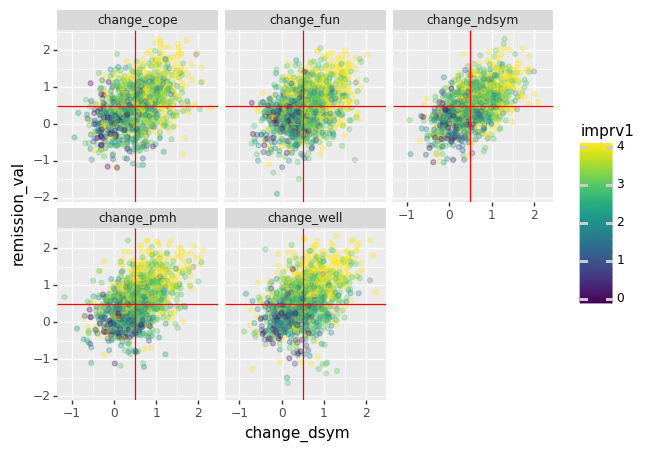

<ggplot: (8789557526004)>

In [83]:
dfM

ggplot(dfMDD_change_long, aes(x='change_dsym', y='remission_val', color = 'imprv1')) + \
     facet_wrap('remission_var') + \
     geom_jitter(alpha = 0.3, width = 0.5) +\
     geom_hline(aes(yintercept=0.5), color = 'red') +\
     geom_vline(aes(xintercept=0.5), color = 'red')



In [147]:
dfMDD_change_long['imprv_cut'] = pd.cut(dfMDD_change_long['imprv1'], bins=[-1,2,4], labels=['low','high'])
dfMDD_change_long.imprv_cut = dfMDD_change_long.imprv_cut.astype('object')

/opt/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.


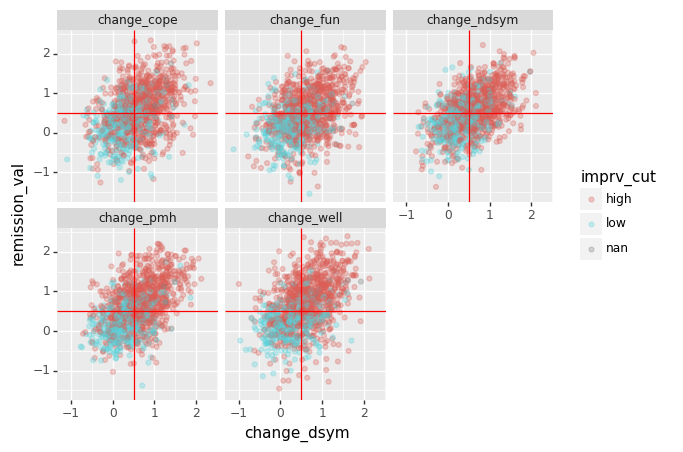

<ggplot: (8789578146633)>

In [148]:

ggplot(dfMDD_change_long, aes(x='change_dsym', y='remission_val', color ='imprv_cut')) +\
     facet_wrap('remission_var') + \
     geom_jitter(alpha = 0.3, width = 0.5) +\
     geom_hline(aes(yintercept=0.5), color = 'red') +\
     geom_vline(aes(xintercept=0.5), color = 'red')



/opt/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.


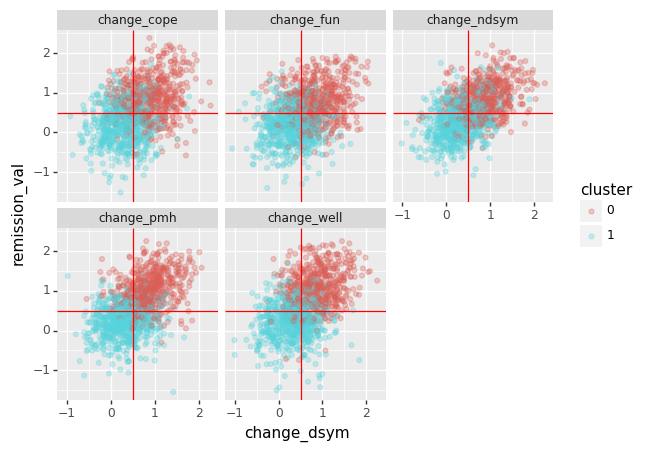

<ggplot: (8789559447748)>

In [112]:
ggplot(dfMDD_change_long, aes(x='change_dsym', y='remission_val', color = 'cluster')) + \
     facet_wrap('remission_var') + \
     geom_jitter(alpha = 0.3, width = 0.5) +\
     geom_hline(aes(yintercept=0.5), color = 'red') +\
     geom_vline(aes(xintercept=0.5), color = 'red')



In [90]:
Xchange

NameError: name 'Xchange' is not defined

In [97]:
#Use the Elbow Method to Decide the Number of Groups in Clustering Analysis 

from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics

X = df[df.mddrnp_1.str.contains('Curr, Prin') | df.mddsnp_1.str.contains('Curr, Prin')]
X[['mddrnp_1', 'mddsnp_1']]
Xpre = X.filter(regex='rdqpre')
Xpost = X.filter(regex='rdqpost') 

Xpre.columns = Xpre.columns.str.replace('pre','')
Xpost.columns = Xpost.columns.str.replace('post','')

Xchange = Xpre.astype('float').subtract(Xpost.astype('float'), axis = 0, fill_value = 0)

Xpost_group = X.filter(regex='^post_')
Xpost_group
Xchange_group = X.filter(regex='^change_')
Xchange_group

#Imputation 
target = Xchange
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(target)
IterativeImputer(random_state=0)
X_imp = imp.transform(target)

kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(X_imp)
kMeans = kmeanModel.labels_

In [98]:
labels.shape

dfMDD['cluster'] = kMeans

/opt/miniconda3/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_jitter : Removed 28 rows containing missing values.


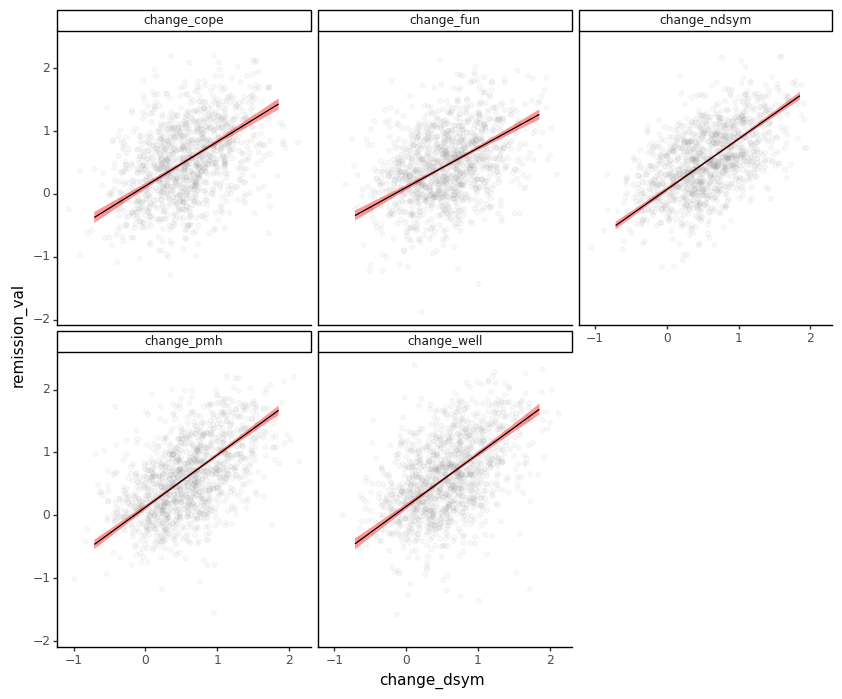

<ggplot: (8789582726903)>

In [24]:
(ggplot(dfMDD_change_long, aes(x='change_dsym', y='remission_val'))
    + facet_wrap('remission_var')
    + geom_jitter(alpha = 0.05, width = 0.5, color = 'grey') 
    + geom_smooth(method='lm', se= True, color = 'black', fill = 'red', size = 0.5)
    + theme_classic()
    + theme(figure_size = (10,8)))

